### Demonstrate a simple NLP pipeline

This notebook demonstrates how to perform four major NLP tasks using the nltk and scikit-learn.

1. Tokenize a corpus of documents: plain text to lists of words
2. Vectorize the documents: lists of words to numerical vectors
3. Dimensionality reduction and clustering (LSA, LDA, word2vec)
4. Classify new documents

Together, the four tasks form a simple text processing pipeline that will permit you to __identify
meaningful clusters of similar documents__ and __assign a new document to one of these clusters__ based on similarity.

The sample data are a subset of tech job descriptions from Dice.com, either for software engineering or managerial roles. Source: Kaggle.

In [1]:
# Import major libraries

%matplotlib inline
from IPython import display
import pylab as plt
import numpy as np
import pandas as pd
# Save python objects
import pickle
# Regular expressions
import re
# CPU time
from time import time

# Include support for sparse vectors/matrices
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics

# Good library for collecting many lists (e.g. the words in a document) 
# into one list (e.g. the words in a corpus)
import itertools

# Low-level NLP library
import nltk, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# High-level NLP library
import gensim

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Read in some data

In [2]:
# Raw data file

rawdf = pd.read_csv('Dice_US_jobs.csv', sep=',', encoding='latin-1')
rawdf.head()

,country_code,date_added,job_board,job_description,job_title,job_type,location,organization,page_url,phone_number,salary,sector
0,US,11/11/2016,https://www.dice.com,"Minimum Required Skills:EDI, TrustedLink, AS2,...",EDI Analyst,"Full Time, Full-time, Employee","Stamford, CT",CyberCoders,https://www.dice.com/jobs/detail/EDI-Analyst-%...,NaN,NaN,"EDI, TrustedLink, AS2, VAN - EDI, TrustedLink,..."
1,US,11/11/2016,https://www.dice.com,"InformaticaåÊ/ ETL DeveloperSt, Petersburg, FL...",Informatica ETL Developer,"Full Time, Full Time","St Petersburg, FL",TrustMinds,https://www.dice.com/jobs/detail/Informatica-E...,NaN,NaN,ETL Informatica B2B Data Exchange Netezza Orac...
2,US,11/11/2016,https://www.dice.com,pmayekar@kanandcorp.com 512-697-8897Sunnyvale ...,Angular developer,"Full Time, Contract Corp-To-Corp, Contract Ind...","Sunnyvale, CA",K Anand Corporation,https://www.dice.com/jobs/detail/Angular-devel...,NaN,NaN,Angular
3,US,11/12/2016,https://www.dice.com,This nationally recognized Microsoft Gold Part...,"Microsoft Dynamics AX, Project Manager",Full Time,"Toronto, Canada, ON",Nigel Frank International,https://www.dice.com/jobs/detail/Microsoft-Dyn...,NaN,NaN,"Microsoft Dynamics AX, Project Manager - Toron..."
4,US,11/11/2016,https://www.dice.com,"Minimum Required Skills:C#, ASP.NET, SQL, Java...",Software Developer,"Full Time, Full-time, Employee","Stamford, CT",CyberCoders,https://www.dice.com/jobs/detail/Software-Deve...,NaN,NaN,"C#, ASP.NET, SQL, JavaScript, MVC - C#, ASP.NE..."


In [3]:
# The columns we're interested in

indf1 = rawdf[['job_description','job_title','sector']].astype('str')
indf1.head()

,job_description,job_title,sector
0,"Minimum Required Skills:EDI, TrustedLink, AS2,...",EDI Analyst,"EDI, TrustedLink, AS2, VAN - EDI, TrustedLink,..."
1,"InformaticaåÊ/ ETL DeveloperSt, Petersburg, FL...",Informatica ETL Developer,ETL Informatica B2B Data Exchange Netezza Orac...
2,pmayekar@kanandcorp.com 512-697-8897Sunnyvale ...,Angular developer,Angular
3,This nationally recognized Microsoft Gold Part...,"Microsoft Dynamics AX, Project Manager","Microsoft Dynamics AX, Project Manager - Toron..."
4,"Minimum Required Skills:C#, ASP.NET, SQL, Java...",Software Developer,"C#, ASP.NET, SQL, JavaScript, MVC - C#, ASP.NE..."


In [4]:
# Filter on manager or developer jobs

indf2 = pd.DataFrame.copy(indf1)

indf2['manager'] = [ int(title.lower().find('manager') >= 0) for title in indf1['job_title'] ]
indf2['developer'] = [ int(title.lower().find('developer') >= 0) for title in indf1['job_title'] ]
indf2 = indf2[(indf2['manager']==1) | (indf2['developer']==1)]
print(indf2.shape)
indf2.head()

(6896, 5)


,job_description,job_title,sector,manager,developer
1,"InformaticaåÊ/ ETL DeveloperSt, Petersburg, FL...",Informatica ETL Developer,ETL Informatica B2B Data Exchange Netezza Orac...,0,1
2,pmayekar@kanandcorp.com 512-697-8897Sunnyvale ...,Angular developer,Angular,0,1
3,This nationally recognized Microsoft Gold Part...,"Microsoft Dynamics AX, Project Manager","Microsoft Dynamics AX, Project Manager - Toron...",1,0
4,"Minimum Required Skills:C#, ASP.NET, SQL, Java...",Software Developer,"C#, ASP.NET, SQL, JavaScript, MVC - C#, ASP.NE...",0,1
6,"Hatstand, a global financial consultancy, is s...",Core Java Developer,"Java, Linux/Unix, SDLC; Multi-Threaded or Conc...",0,1


### 1. Tokenize a corpus of documents

The dataframe indf2 contains ~7000 job descriptions that we have divided into either 'manager' or 'developer' categories based ont the job title. Using only the job descriptions, __not the title__, we would like to identify clusters of similar documents and build a model that permits us to map new documents to either the manager or developer role.

Note that our ability to classify new jobs as 'manager' or 'developer' without the title is a hypothesis. Does the content of these job descriptions really differ enough to do this accurately?

Each document is a string. Before building a numerical model of the documents, we need to __tokenize__ the strings. This means that we try our best to split them into lists of words, abbreviations, numbers, and other units of meaning.

There are many obvious methods to partially tokenize a string, such as `document.split(' ')`. But in order to capture most of the words as independent tokens, we need to combine several methods.  

This next cell shows a brief example of the tokenizing process using the NLTK library.

We will need:
* a list of words appearing in order for each job description
* a list of words in the set of all job descriptions (the corpus)

In [5]:
# The raw job description data is a List of strings--these are our 'documents'

rawdes = indf2['job_description'].values.tolist()
print('The document collection consists of',len(rawdes),'strings')

# This sequence creates a list of all words in the corpus.

# Concatenate the corpus into a single string
raw_corpus = ''.join(rawdes)
# This NLTK method produces a list of sentences from the raw corpus: raw2 is [str]
raw2_corpus = nltk.sent_tokenize(raw_corpus) 
# This NLTK method splits each sentence into a word list: raw3 is [[str]]
raw3_corpus =  [nltk.word_tokenize(sent) for sent in raw2_corpus] 
# Join all word lists into a single word list
allwords_corpus = list(itertools.chain(*raw3_corpus))

# Note that printing allwords_corpus raises a NotebookApp.iopub error (too long)

print('The document collection has',len(allwords_corpus),'words')
print('(Without removing punctuation and stop words, or stemming)')

The document collection consists of 6896 strings
The document collection has 2614472 words
(Without removing punctuation and stop words, or stemming)


In [6]:
# The nltk object 'FreqDist' calculates and manipulates frequency distributions.
# As you can see, the most common words are pretty useless.

fdist1 = nltk.FreqDist(allwords_corpus)
print(fdist1)
fdist1.most_common(20)

<FreqDist with 99987 samples and 2614472 outcomes>


[(',', 161758),
 ('and', 106764),
 ('to', 77072),
 ('the', 53249),
 ('of', 46719),
 ('.', 44655),
 ('with', 42697),
 ('in', 38653),
 ('a', 36778),
 ('for', 29702),
 (':', 25294),
 ('experience', 18115),
 ('-', 15730),
 (')', 15599),
 ('is', 15469),
 ('be', 15150),
 ('or', 14975),
 ('(', 14934),
 ('are', 13863),
 ('!', 13679)]

#### Why so many words?

Our collection of 7000 job descriptions has about 2.5 million tokens, so we're looking at about 300 tokens per document. As the frequency distribution above shows, these include tokens for individual punctuation symbols : '.', ',', etc. 

Obviously, many of these tokens are completely uninteresting. We want to remove __stop words__, which are common pronouns, prepositions and articles. NLTK has standard lists in most languages: `stopwords.words('english')` below is an example. 

We also want to remove punctuation, unless that punctuation is part of a token. The NLTK method word_tokenize is usually smart enough to retain cases such as "Dr." and "can't" as single tokens while parsing out other punctuation. However, infixed punctuation such as '...five years experience.The candidate...' is a common problem in web scraped data, so we wrote a little
regex function to treat such cases.

Finally, after dropping stop words and punctuation, we want to replace multiple forms of the same word with their common root, for example:
* bring, brought, brang, bringing --> bring
* knife, knives --> knife
This step is called 'stemming' the tokens. NLTK has several stemmer variants, which different performance characteristics for rare exceptions. The Porter stemmer is good enough for most applications that do not involve tagging the part of speech.

In [7]:
# Build a 'tokenizer' function that takes a string and returns a list of meaningful tokens

# This custom function deals with a common problem in web-scraped text:
# uncaptured whitespace around punctuation and between sentences.
# The regex specifically captures patterns like _(word)(punc)(word)_ and 
# replaces the infixed punctuation with whitespace. Note that the single
# apostrophe is left out of the punctuation list because it is often infixed.
def clean_sentence_punct(text):
    pattern = re.compile(r'\b([\w\d]*)([.,;:/"\(\)\*\\]+)([\w\d]*)\b')
    return re.sub(pattern, r'\1 \3', text)

# This function assumes a string input, and does both tokenization and stemming.
def text_stemmed_and_stopped(text):
    allstems = []
    # convert to lowercase, replace infixed punctuation with space, split into sentences.
    sentences = nltk.sent_tokenize(clean_sentence_punct(text.lower()))
    words_per_sentence =  [nltk.word_tokenize(sent) for sent in sentences]
    allwords_in_text = list(itertools.chain(*words_per_sentence))
    # Define as set for faster 'not in' test
    sw = set(stopwords.words('english'))
    sw_and_punct = sw.union(set('''.,:;()*#&-_%!?/\'")'''))
    # collect list of meaningful tokens, stemmed.
    for item in allwords_in_text:
        if item not in sw_and_punct:
            allstems.append(PorterStemmer().stem(item))
    return allstems

# This function can be used with scikit-learn to override its native stemmer with 
# the Porter stemmer from nltk. Note that it takes a [str] argument.
def tokenize(wordlist):
    stems = []
    for word in wordlist:
        stems.append(PorterStemmer().stem(word))
    return stems

# Test function
oldtext_str = 'We are bringing cake to the party.'
newtext_str = text_stemmed_and_stopped(oldtext_str)
oldtext_dirty = 'Jim is coming to my party.He will bring:cake, soda, and ice cream.'
newtext_dirty = text_stemmed_and_stopped(oldtext_dirty)
oldtext_list = ['We','are','bringing','cake','to','the','party','.']
newtext_list = tokenize(oldtext_list)
newtext_clean = clean_sentence_punct(oldtext_dirty)

print('Results of tokenize() function:')
print('Input:', oldtext_list)
print('Output:', newtext_list)
print()
print('Results of clean_sentence_punct() function:')
print('Input:',oldtext_dirty)
print('Output:',newtext_clean)
print()
print('Results of text_stemmed_and_stopped() function:')
print('Input:', oldtext_str)
print('Output:', newtext_str)
print('Input:', oldtext_dirty)
print('Output:', text_stemmed_and_stopped(oldtext_dirty))

Results of tokenize() function:
Input: ['We', 'are', 'bringing', 'cake', 'to', 'the', 'party', '.']
Output: ['We', 'are', 'bring', 'cake', 'to', 'the', 'parti', '.']

Results of clean_sentence_punct() function:
Input: Jim is coming to my party.He will bring:cake, soda, and ice cream.
Output: Jim is coming to my party He will bring cake, soda, and ice cream.

Results of text_stemmed_and_stopped() function:
Input: We are bringing cake to the party.
Output: ['bring', 'cake', 'parti']
Input: Jim is coming to my party.He will bring:cake, soda, and ice cream.
Output: ['jim', 'come', 'parti', 'bring', 'cake', 'soda', 'ice', 'cream']


In [8]:
# Try it on the corpus: takes about 45s for 7000 documents
rawdes_tokenized = [text_stemmed_and_stopped(doc) for doc in rawdes]

In [9]:
allwords_in_corpus = list(itertools.chain(*rawdes_tokenized))
fdist2 = nltk.FreqDist(allwords_in_corpus)
print(fdist2)
fdist2.most_common(20)

<FreqDist with 59434 samples and 1599776 outcomes>


[('develop', 29829),
 ('experi', 26607),
 ('work', 23567),
 ('manag', 16202),
 ('requir', 15568),
 ('applic', 14701),
 ('project', 13993),
 ('team', 11128),
 ('skill', 10307),
 ('posit', 10029),
 ('year', 9966),
 ('design', 9093),
 ('busi', 9068),
 ('resum', 8336),
 ('appli', 8186),
 ('\x95à', 8177),
 ('look', 7863),
 ('softwar', 7745),
 ('pleas', 7732),
 ('technolog', 7279)]

### 2. Vectorize the documents

You can see that we've already simplified the document representation quite a lot just by cleaning the documents a little bit. Stemming, removing stop words, and ignoring punctuation reduced the total number of words from 2.5m to 1.5m ('outcomes'), and the number of unique words in the corpus from about 100k to about 60k ('samples').

Now, a bag-of-words model would represent each document as a frequency vector with 60k components, which is far too many for clustering. Also, a bag-of-words model treats all tokens equally, which is still not the right thing to do since tokens that appear in every document are less meaningful than tokens that appear only in a few documents.

#### TF-IDF is the first step to dimensionality reduction

The _least_ we can do is replace token frequencies with TF-IDF ratios. This step does not reduce the _formal_ dimensionality of the data, in the sense that each document vector still has 60k components, but it does reduce the _inherent_ dimensionality of the data because it tends to result in sparser vectors (more contrast in the vector coefficients of common and rare words). In practice, matrix factorization methods work much better on TF-IDF vectors than bag-of-words vectors.

The next cells show how to convert documents to TF-IDF vectors using scikit-learn.

In [10]:
# TFIDF vectorizer

# Default options include: conversion to lowercase, encoding utf-8, token is 2+ alphanumeric chars
# but no punctuation. I don't think that lowercase conversion and punctuation stripping still work when
# we replace the tokenizer with a custom function, which is why I added them to the process above. 

# This works fine if the custom tokenizer handles splitting and stemming

# Define the model characteristics
tfidf = TfidfVectorizer(tokenizer=text_stemmed_and_stopped, max_features=1000)
# Fit the model to the corpus and tranform each document to a vector
tfs = tfidf.fit_transform(rawdes)

# Options to consider: norm='l1' for sparser tfidf vectors? binary='True' to avoid 
# multiplying the tf of repeated terms in the same document. Max_features=N to keep
# the top N terms ordered by TF across corpus. max_df, min_df (floats) to place
# limits on document frequency of terms

print(tfs.shape)
print(tfs[0])

(6896, 1000)
  (0, 340)	0.466704014857
  (0, 396)	0.0976586262095
  (0, 906)	0.0876804272856
  (0, 282)	0.100577412129
  (0, 679)	0.0599081564455
  (0, 987)	0.172483389509
  (0, 351)	0.127259702717
  (0, 686)	0.162228500399
  (0, 158)	0.154893747621
  (0, 827)	0.457236823247
  (0, 243)	0.167576241466
  (0, 835)	0.171276337414
  (0, 533)	0.132992240182
  (0, 621)	0.1009651196
  (0, 885)	0.0728090113667
  (0, 802)	0.129826451172
  (0, 625)	0.121208874449
  (0, 592)	0.134216438688
  (0, 82)	0.108226942208
  (0, 833)	0.0495124864445
  (0, 690)	0.119022938759
  (0, 244)	0.0953511220864
  (0, 63)	0.13494321122
  (0, 977)	0.0458046915268
  (0, 395)	0.150975866271
  (0, 910)	0.182263827731
  (0, 763)	0.0997594044318
  (0, 339)	0.106264480354
  (0, 148)	0.193099639105
  (0, 493)	0.0935160970468
  (0, 149)	0.157425370543
  (0, 712)	0.0835206498429
  (0, 926)	0.0809092701708
  (0, 92)	0.0511856239475
  (0, 482)	0.239928402113
  (0, 554)	0.149396717317
  (0, 548)	0.0628119117296


Notice that the output of the TfIdfVectorizer is a sparse vector for each document, which is essential for NLP to avoid running into memory problems!

### 3. Dimensionality reduction and clustering


(6896, 1000)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


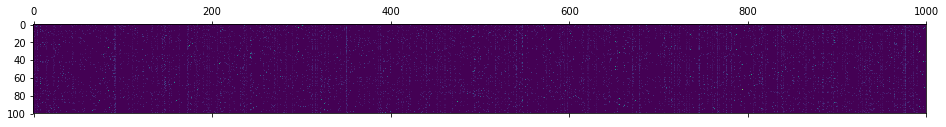

In [11]:
# Here is our data matrix of the first 100 documents, using the 1000 most common tokens in the corpus:

print(tfs.shape)
print(type(tfs))
print(type(tfs.todense()))
plt.matshow(tfs[:100,:].todense(), vmin=0, vmax=1)

In [12]:
# Latent semantic analysis reduces this representation from 1000 dimensions to N dimensions.
# The scikit-learn representation is TruncatedSVD.

# Let's try N=2:

lsa = TruncatedSVD(n_components=2, random_state=42)
docs_lsa = lsa.fit_transform(tfs)
print(docs_lsa.shape)

(6896, 2)


Text(0,0.5,'LSA_2 Topic 1')

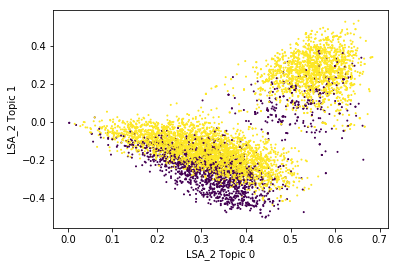

In [13]:
# We do indeed see two major clusters in the data, 
# but they don't correspond to developer/manager split!

colors=indf2['developer'].values
plt.scatter(docs_lsa[:,0],docs_lsa[:,1],c=colors, s=1)
plt.xlabel('LSA_2 Topic 0')
plt.ylabel('LSA_2 Topic 1')

In [14]:
# Create index-to-term dictionary
reverse_vocab = dict([(v,k) for k,v in tfidf.vocabulary_.items()])

In [38]:
# What do the topics represent? In this 2-topic representation, we see that the first topic 
# captures standard job description while the second topic captures disclaimers ('compliance',
# 'feder', 'ident', 'origin', 'race', 'religion'...). This explains the low correspondence between
# the clusters and the developer/manager flags.
#
# Like the first component of PCA, the zeroth topic in LSA functions like an 'intercept' consisting 
# of generic terms present in nearly all documents.
#

# Topic 0:
strong_idx = np.where(np.abs(lsa.components_[0,:]) > 0.1)[0]
strong_terms_0 = [reverse_vocab[idx] for idx in strong_idx]
print('Topic 0 terms:')
print(strong_terms_0)
print('')

# Topic 1:
strong_idx = np.where(np.abs(lsa.components_[1,:]) > 0.1)[0]
strong_terms_1 = [reverse_vocab[idx] for idx in strong_idx]
print('Topic 1 terms:')
print(strong_terms_1)

Topic 0 terms:
['appli', 'applic', 'develop', 'experi', 'look', 'manag', 'pleas', 'posit', 'project', 'receiv', 'requir', 'resum', 'softwar', 'work']

Topic 1 terms:
['appli', 'busi', 'click', 'elig', 'forward', 'hire', 'law', 'look', 'manag', 'pleas', 'posit', 'project', 'protect', 'receiv', 'resum', 'right', 'åê']


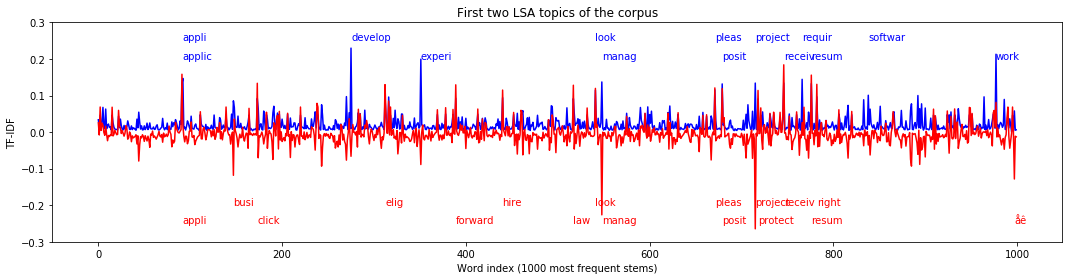

In [40]:
fig = plt.figure(figsize=(15,4))

plt.ylim((-0.3,0.3))
plt.plot(lsa.components_[0,:], color='b')
plt.plot(lsa.components_[1,:], color='r')
yc = 0.25
for word in strong_terms_0:
    xc = tfidf.vocabulary_[word]
    plt.text(xc,yc,word, color='b')
    if (yc == 0.25):
        yc = 0.2
    else:
        yc = 0.25
yc = -0.25
for word in strong_terms_1:
    xc = tfidf.vocabulary_[word]
    plt.text(xc,yc,word, color='r')
    if (yc == -0.25):
        yc = -0.2
    else:
        yc = -0.25
        
plt.xlabel('Word index (1000 most frequent stems)')
plt.ylabel('TF-IDF')
plt.title('First two LSA topics of the corpus')
fig.tight_layout()
fig.savefig('BasicNLP_FirstTwoTopics.png')

In [18]:
# Let's be a little more ambitious and set N=4:

lsa4 = TruncatedSVD(n_components=4, random_state=42)
docs_lsa4 = lsa4.fit_transform(tfs)
print(docs_lsa4.shape)

words_to_show = 40
pct_to_show = 100. * (1. - (words_to_show/tfs.shape[1]))

# Topic 0:
threshold = np.percentile(lsa4.components_[0,:],pct_to_show)
strong_idx = np.where(lsa4.components_[0,:] > threshold)[0]
strong_terms = [reverse_vocab[idx] for idx in strong_idx]
print('Topic 0 terms:')
print(strong_terms)
print('')

# Topic 1:
threshold = np.percentile(lsa4.components_[1,:], pct_to_show)
strong_idx = np.where(lsa4.components_[1,:] > threshold)[0]
strong_terms = [reverse_vocab[idx] for idx in strong_idx]
print('Topic 1 terms:')
print(strong_terms)
print('')

# Topic 2:
threshold = np.percentile(lsa4.components_[2,:], pct_to_show)
strong_idx = np.where(lsa4.components_[2,:] > threshold)[0]
strong_terms = [reverse_vocab[idx] for idx in strong_idx]
print('Topic 2 terms:')
print(strong_terms)
print('')

# Topic 3:
threshold = np.percentile(lsa4.components_[3,:], pct_to_show)
strong_idx = np.where(lsa4.components_[3,:] > threshold)[0]
strong_terms = [reverse_vocab[idx] for idx in strong_idx]
print('Topic 3 terms:')
print(strong_terms)

(6896, 4)
Topic 0 terms:
['appli', 'applic', 'busi', 'c', 'click', 'compani', 'data', 'design', 'develop', 'elig', 'employ', 'experi', 'forward', 'hire', 'java', 'javascript', 'law', 'look', 'manag', 'need', 'opportun', 'pleas', 'posit', 'product', 'project', 'protect', 'receiv', 'requir', 'resum', 'right', 'servic', 'skill', 'softwar', 'sql', 'system', 'team', 'technolog', 'web', 'work', 'year']

Topic 1 terms:
["'click", '1999', '2016', 'appli', 'bottom', 'characterist', 'click', 'copyright', 'cybercod', 'cybercoderscybercod', 'directli', 'elig', 'employ', 'employeral', 'feder', 'fit', 'form', 'forward', 'go', 'hire', 'inc', 'law', 'link', 'look', 'pleas', 'posit', 'protect', 'proud', 'receiv', 'reserv', 'resum', 'right', 'search', 'today', 'upon', 'verif', 'verifi', 'work', 'you.-', 'å©']

Topic 2 terms:
['appli', 'assign', 'budget', 'busi', 'chang', 'click', 'complet', 'coordin', 'cost', 'deliver', 'deliveri', 'elig', 'employ', 'ensur', 'execut', 'facilit', 'forward', 'hire', 'law'

Text(0,0.5,'LSA_4 Topic 3')

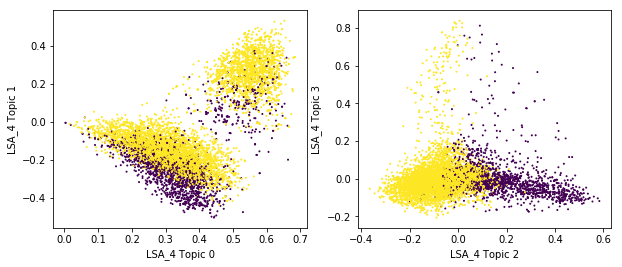

In [19]:
# Now we're getting somewhere: Topic 2 clearly contains terms that we mainly find in management roles.

# A good approach to split managers from developers more clearly might be to remove terms
# related to compliance from the corpus, or remove paragraphs enriched in those terms, then remodel.

fig = plt.figure(figsize=(10,4))

colors=indf2['developer'].values

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(docs_lsa4[:,0],docs_lsa4[:,1],c=colors, s=1)
ax1.set_xlabel('LSA_4 Topic 0')
ax1.set_ylabel('LSA_4 Topic 1')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(docs_lsa4[:,2],docs_lsa4[:,3],c=colors, s=1)
ax2.set_xlabel('LSA_4 Topic 2')
ax2.set_ylabel('LSA_4 Topic 3')

In [20]:
# Identify the two clusters, even though they are kind of obvious by eye.

km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1,
                verbose=True)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(docs_lsa)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 132.778618142
start iteration
done sorting
end inner loop
Iteration 1, inertia 119.939987518
start iteration
done sorting
end inner loop
Iteration 2, inertia 119.735181164
start iteration
done sorting
end inner loop
Iteration 3, inertia 119.73133861
center shift 4.927164e-04 within tolerance 3.475529e-06
done in 0.036s



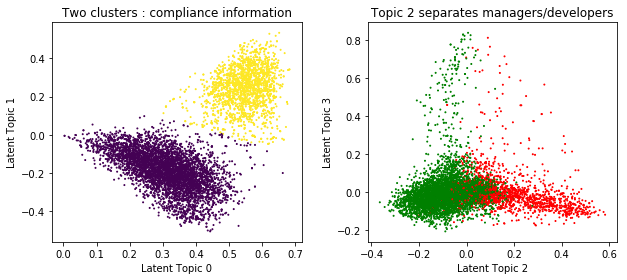

In [44]:
# Figure demonstrating the distinction between statistical clusters in the corpus and 
# document classification in the corpus.

fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(wspace=0.4,hspace=0.4)

colors=indf2['developer'].values

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(docs_lsa4[:,0],docs_lsa4[:,1],c=km.labels_, s=1)
ax1.set_xlabel('Latent Topic 0')
ax1.set_ylabel('Latent Topic 1')
ax1.set_title('Two clusters : compliance information')

devcolors = np.where(colors==0,'r','g')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(docs_lsa4[:,2],docs_lsa4[:,3],c=devcolors, s=1)
ax2.set_xlabel('Latent Topic 2')
ax2.set_ylabel('Latent Topic 3')
ax2.set_title('Topic 2 separates managers/developers')

fig.tight_layout()
fig.savefig('BasicNLP_clusters_and_topics.png')

In [45]:
# Statistics of the clustering : the clusters have nothing to do with the manager/developer split.

print("Homogeneity: %0.3f" % metrics.homogeneity_score(indf2['developer'], km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(indf2['developer'], km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(indf2['developer'], km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(indf2['manager'], km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tfs, km.labels_, sample_size=1000))

Homogeneity: 0.034
Completeness: 0.030
V-measure: 0.032
Adjusted Rand-Index: -0.037
Silhouette Coefficient: 0.048
